## Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,Bidirectional,LSTM,Embedding, Masking
from keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import ast


## Loading data

In [2]:
def load_data(data_path):   #function for data loading

    data = pd.read_csv(data_path)

    data.dropna(inplace=True)
    print("Number of rows : ",data.shape[0]," and the number of columns : ",data.shape[1])

    return data

In [5]:
data = load_data("ner.csv")

Number of rows :  47959  and the number of columns :  4


In [6]:
data.sample(5).sample(5).style.set_properties(
    **{
        'background-color': '#ffffff',  # White background
        'color': '#000000',             # Black text
        'font-weight': 'bold',
        'font-style': 'italic'
    }
)


,Sentence #,Sentence,POS,Tag
34899,Sentence: 34900,"Television coverage showed at least one demonstrator being handcuffed , and one police officer on the ground .","['NN', 'NN', 'VBD', 'IN', 'JJS', 'CD', 'NN', 'VBG', 'VBN', ',', 'CC', 'CD', 'NN', 'NN', 'IN', 'DT', 'NN', '.']","['B-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
19729,Sentence: 19730,Officers arrested four people and confiscated two guns and ammunition from the raid on two houses .,"['NNS', 'VBN', 'CD', 'NNS', 'CC', 'VBD', 'CD', 'NNS', 'CC', 'NN', 'IN', 'DT', 'NN', 'IN', 'CD', 'NNS', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
12067,Sentence: 12068,They are demanding Israel stop building settlements in these areas .,"['PRP', 'VBP', 'VBG', 'NNP', 'VB', 'VBG', 'NNS', 'IN', 'DT', 'NNS', '.']","['O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
47442,Sentence: 47443,"In Denmark , authorities have released two of seven people arrested last month on suspicion of planning an attack in Europe .","['IN', 'NNP', ',', 'NNS', 'VBP', 'VBN', 'CD', 'IN', 'CD', 'NNS', 'VBN', 'JJ', 'NN', 'IN', 'NN', 'IN', 'VBG', 'DT', 'NN', 'IN', 'NNP', '.']","['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O']"
2972,Sentence: 2973,A Saudi Interior Ministry spokesman says three French nationals have been killed in northwestern Saudi Arabia .,"['DT', 'JJ', 'NNP', 'NNP', 'NN', 'VBZ', 'CD', 'JJ', 'NNS', 'VBP', 'VBN', 'VBN', 'IN', 'JJ', 'NNP', 'NNP', '.']","['O', 'B-org', 'I-org', 'I-org', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O']"


## Preprocessing data

In [7]:
def preprocess_data(data):
    for i in range(len(data)):
        pos = ast.literal_eval(data.loc[i, 'POS'])
        tags = ast.literal_eval(data.loc[i, 'Tag'])
        data.loc[i, 'POS'] = [str(word) for word in pos]
        data.loc[i, 'Tag'] = [str(word.upper()) for word in tags]
    return data

In [8]:
data = preprocess_data(data)

In [9]:
data.sample(5).sample(5).style.set_properties(
    **{
        'background-color': '#ffffff',  # White background
        'color': '#000000',             # Black text
        'font-weight': 'bold',
        'font-style': 'italic'
    }
)


,Sentence #,Sentence,POS,Tag
46231,Sentence: 46232,A White House statement Tuesday says the ban is a sign of serious concern about the Burmese regime 's continuing refusal to move towards democracy .,"['DT', 'NNP', 'NNP', 'NN', 'NNP', 'VBZ', 'DT', 'NN', 'VBZ', 'DT', 'NN', 'IN', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'NN', 'POS', 'VBG', 'NN', 'TO', 'VB', 'IN', 'NN', '.']","['O', 'B-ORG', 'I-ORG', 'O', 'B-TIM', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
19575,Sentence: 19576,Early reports from the camp near Qaim say at least two U.S. personnel were wounded in the attack .,"['RB', 'NNS', 'IN', 'DT', 'NN', 'IN', 'NNP', 'VBP', 'IN', 'JJS', 'CD', 'NNP', 'NNS', 'VBD', 'VBN', 'IN', 'DT', 'NN', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'B-GEO', 'O', 'O', 'O', 'O', 'B-GEO', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
16493,Sentence: 16494,Violence in Indian-controlled Kashmir has declined since India and Pakistan entered into a peace process in 2004 .,"['NN', 'IN', 'JJ', 'NNP', 'VBZ', 'VBN', 'IN', 'NNP', 'CC', 'NNP', 'VBD', 'IN', 'DT', 'NN', 'NN', 'IN', 'CD', '.']","['O', 'O', 'O', 'B-GEO', 'O', 'O', 'O', 'B-GEO', 'O', 'B-GEO', 'O', 'O', 'O', 'O', 'O', 'O', 'B-TIM', 'O']"
23368,Sentence: 23369,"U.S. and Iraqi troops have carried out airstrikes in the Euphrates River Valley , killing 37 insurgents .","['NNP', 'CC', 'JJ', 'NNS', 'VBP', 'VBN', 'RP', 'NNS', 'IN', 'DT', 'NNP', 'NNP', 'NNP', ',', 'VBG', 'CD', 'NNS', '.']","['B-GEO', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O']"
29547,Sentence: 29548,"American skier Daron Rahlves has won his third World Cup men 's downhill race of the season by beating Austrian Michael Walchhofer in Wengen , Switzerland .","['JJ', 'NN', 'NNP', 'NNP', 'VBZ', 'VBN', 'PRP$', 'JJ', 'NNP', 'NNP', 'NNS', 'POS', 'NN', 'NN', 'IN', 'DT', 'NN', 'IN', 'VBG', 'JJ', 'NNP', 'NNP', 'IN', 'NNP', ',', 'NNP', '.']","['B-GPE', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GPE', 'B-PER', 'I-PER', 'O', 'B-GEO', 'O', 'B-GEO', 'O']"


## Train Test Split

In [10]:
df_final = data[['Sentence','Tag']]

In [11]:
df_train,df_test = train_test_split(df_final,test_size=0.2,random_state=42)
len(df_train),len(df_test)

(38367, 9592)

## Tokenization

In [12]:
train_targets = list(df_train.Tag.values)  # Convert training target labels to a list
test_targets = list(df_test.Tag.values)    # Convert testing target labels to a list

tokenizer = Tokenizer(lower=False, oov_token="UNK")  # Initialize tokenizer with case sensitivity and OOV token
tokenizer.fit_on_texts(df_train['Sentence'])  # Fit tokenizer on training sentences to build vocabulary

train_inputs = tokenizer.texts_to_sequences(df_train['Sentence'])  # Convert training sentences to sequences of integers
test_inputs = tokenizer.texts_to_sequences(df_test['Sentence'])    # Convert testing sentences to sequences of integers


In [13]:
word2idx = tokenizer.word_index
V = len(word2idx) # Vocab size
print("Found %s unique tokens "%V)

Found 28761 unique tokens 


In [14]:
train_tags = set([val for sublist in train_targets for val in sublist])    # Flatten the list of training targets and get unique tags
test_tags = set([val for sublist in test_targets for val in sublist])

print("Unique NER tags in train set: ",train_tags)
print("Unique NER tags in test set: ",test_tags)

Unique NER tags in train set:  {'O', 'I-TIM', 'B-TIM', 'B-NAT', 'I-ORG', 'I-NAT', 'B-EVE', 'B-GEO', 'B-ART', 'I-ART', 'B-GPE', 'B-PER', 'I-PER', 'I-EVE', 'I-GEO', 'I-GPE', 'B-ORG'}
Unique NER tags in test set:  {'O', 'I-TIM', 'B-TIM', 'B-NAT', 'I-ORG', 'I-NAT', 'B-EVE', 'B-GEO', 'B-ART', 'I-ART', 'B-PER', 'B-GPE', 'I-PER', 'I-EVE', 'I-GEO', 'I-GPE', 'B-ORG'}


In [15]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_tgt_int = tag_tokenizer.texts_to_sequences(train_targets)
test_tgt_int = tag_tokenizer.texts_to_sequences(test_targets)

In [16]:
# Get the actual vocabulary size after tokenization
V = len(tokenizer.word_index) + 1  # +1 for padding or OOV token
print("Found %s unique tokens "%V)

Found 28762 unique tokens 


In [17]:
# Max length
max_length_train = max(len(sent) for sent in train_inputs)
max_length_test = max(len(sent) for sent in test_inputs)
max_length = max(max_length_train,max_length_test)

# Pad input sequences
train_inputs_final = pad_sequences(train_inputs,maxlen=max_length,padding="post")
print("Shape of train inputs: ",train_inputs_final.shape)

test_inputs_final = pad_sequences(test_inputs,maxlen=max_length,padding="post")
print("Shape of test inputs: ",test_inputs_final.shape)

train_targets_final = pad_sequences(train_tgt_int,maxlen=max_length,padding="post")
print("Shape of train targets: ",train_targets_final.shape)

test_targets_final = pad_sequences(test_tgt_int,maxlen=max_length,padding="post")
print("Shape of test targets: ",test_targets_final.shape)

Shape of train inputs:  (38367, 89)
Shape of test inputs:  (9592, 89)
Shape of train targets:  (38367, 89)
Shape of test targets:  (9592, 89)


In [18]:
# Number of classes

K = len(tag_tokenizer.word_index)  +1 # No of classes
print("Found %s unique classes "%K)

Found 18 unique classes 


## Model 1- LSTM (Long Short term memory)

In [19]:
from tensorflow.keras.models import Sequential

In [20]:
max_length = 89
V = 28762
K = 18

In [21]:
vector_size = 16
i = Input(shape=(max_length,))
x = Embedding(input_dim=V+1, output_dim=vector_size, mask_zero=True)(i)
x = Masking()(x)  # Masking layer to handle variable length sequences
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 89)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 89, 16)         │        460,208 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 89, 16)         │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 89, 16)         │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 89)             │              0 │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 89, 64)         │         12,544 │ masking[0][0],         │
│ (Bidirectional)           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 89, 18)         │          1,170 │ bidirectional[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 473,922 (1.81 MB)

 Trainable params: 473,922 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model with the custom F1Score metric
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Model Training

In [24]:
print(f"train_inputs_final shape: {train_inputs_final.shape}")
print(f"train_targets_final shape: {train_targets_final.shape}")
print(f"test_inputs_final shape: {test_inputs_final.shape}")
print(f"test_targets_final shape: {test_targets_final.shape}")

train_inputs_final shape: (38367, 89)
train_targets_final shape: (38367, 89)
test_inputs_final shape: (9592, 89)
test_targets_final shape: (9592, 89)


In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Mount Google Drive (if saving to Google Drive)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [26]:
# Define the path to save the model checkpoint
checkpoint_path = "/content/drive/MyDrive/NER_nltk/model_checkpoint.keras"  # You can customize the path here

# Define callbacks
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(
    train_inputs_final,
    train_targets_final,
    epochs=10,
    validation_data=(test_inputs_final, test_targets_final),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9179 - loss: 0.3827
Epoch 1: val_loss improved from inf to 0.14094, saving model to /content/drive/MyDrive/NER_nltk/model_checkpoint.keras
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 151s 122ms/step - accuracy: 0.9179 - loss: 0.3826 - val_accuracy: 0.9580 - val_loss: 0.1409
Epoch 2/10
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9611 - loss: 0.1293
Epoch 2: val_loss improved from 0.14094 to 0.11029, saving model to /content/drive/MyDrive/NER_nltk/model_checkpoint.keras
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 193s 114ms/step - accuracy: 0.9611 - loss: 0.1293 - val_accuracy: 0.9654 - val_loss: 0.1103
Epoch 3/10
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9681 - loss: 0.0993
Epoch 3: val_loss improved from 0.11029 to 0.09862, saving model to /content/drive/MyDrive/NER_nltk/model_checkpoint.keras
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - accuracy: 0.9681 - loss: 0.0993 - val_accuracy: 0.9685 - val_loss: 0.0

In [27]:
# Save the model to a file using tf.keras.models.save_model()
tf.keras.models.save_model(model, "ner_model.h5")

## Model Training Graph

In [28]:
sns.set(style="whitegrid")

# Get training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Calculate differences
loss_diff = [train_loss[i] - val_loss[i] for i in range(len(train_loss))]
acc_diff = [train_acc[i] - val_acc[i] for i in range(len(train_acc))]


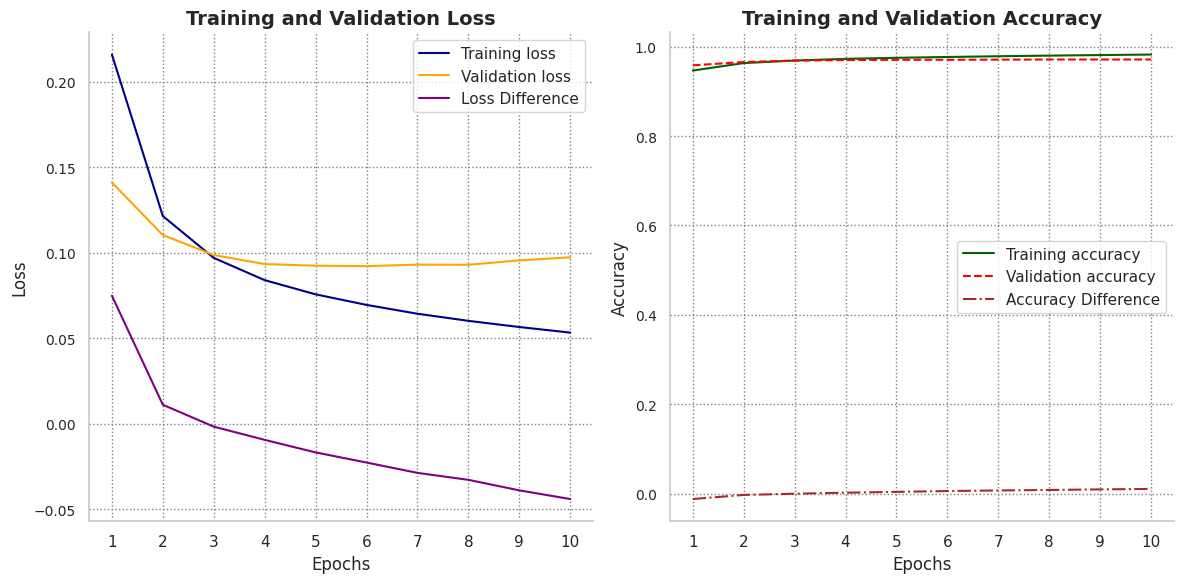

In [29]:
# Plot training and validation loss in subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'darkblue', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.plot(epochs, loss_diff, 'purple', label='Loss Difference')
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', color='gray')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(epochs)
plt.yticks(fontsize=10)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)  # Create the second subplot
plt.plot(epochs, train_acc, 'darkgreen', label='Training accuracy')
plt.plot(epochs, val_acc, 'red', linestyle='--', label='Validation accuracy')
plt.plot(epochs, acc_diff, 'brown', linestyle='-.', label='Accuracy Difference')
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)  # X-axis label with larger font size
plt.ylabel('Accuracy', fontsize=12)  # Y-axis label with larger font size
plt.legend()  # Display the legend
plt.grid(True, linestyle=':', color='gray')  # Add grid lines with dotted style and gray color
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(epochs)
plt.yticks(fontsize=10)

plt.tight_layout()  # Adjust layout to prevent overlap of subplots

# Show plot
plt.show()  # Display the plot


## Model Prediction

In [30]:
unique_tags = ['O', 'B-GEO', 'B-GPE', 'B-ORG', 'B-PER', 'B-ART', 'B-EVE', 'B-NAT', 'B-TIM',
               'I-GEO', 'I-GPE', 'I-ORG', 'I-PER', 'I-ART', 'I-EVE', 'I-NAT', 'I-TIM', 'PAD']  # Added 'PAD' tag

In [31]:
# Define your sample sentence
sentence = "Polish Prime Minister Jaroslaw Kaczynski has voiced support for the deployment of 10 U.S. missile interceptors in Poland and guidance technology in the Czech Republic."

# Preprocess the sentence
tokenized_sentence = tokenizer.texts_to_sequences([sentence])
padded_sentence = pad_sequences(tokenized_sentence, maxlen=max_length, padding="post")

# Make predictions
predictions = model.predict(padded_sentence)
prediction_ner = np.argmax(predictions, axis=-1)

# Check the shapes and classes
print(f"Shape of predictions array: {predictions.shape}")
print(f"Number of unique tags: {len(unique_tags)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Shape of predictions array: (1, 89, 18)
Number of unique tags: 18


In [32]:
# Ensuring the number of classes matches the length of unique_tags
assert len(unique_tags) == predictions.shape[-1], "Number of classes does not match the length of unique tags"

# Get the predicted tags
predicted_tags = [[unique_tags[idx] for idx in sentence] for sentence in prediction_ner]

# Example sentence and its predictions
example_sentence = sentence.split()  # Use sentence tokens instead of dummy 'tokens'
example_predictions = predicted_tags[0]

# Displaying the tokens with their predicted tags
from tabulate import tabulate
table = [[token, tag] for token, tag in zip(example_sentence, example_predictions)]
print(tabulate(table, headers=["Token", "Predicted NER Tag"], tablefmt="grid"))

+--------------+---------------------+
| Token        | Predicted NER Tag   |
+==============+=====================+
| Polish       | B-TIM               |
+--------------+---------------------+
| Prime        | B-EVE               |
+--------------+---------------------+
| Minister     | B-ART               |
+--------------+---------------------+
| Jaroslaw     | B-ART               |
+--------------+---------------------+
| Kaczynski    | B-ART               |
+--------------+---------------------+
| has          | B-GEO               |
+--------------+---------------------+
| voiced       | B-GEO               |
+--------------+---------------------+
| support      | B-GEO               |
+--------------+---------------------+
| for          | B-GEO               |
+--------------+---------------------+
| the          | B-GEO               |
+--------------+---------------------+
| deployment   | B-GEO               |
+--------------+---------------------+
| of           | B-GEO   

## Model Prediction Graph

<ipython-input-33-71758b49be61>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_tags, y=predictions[0][0], palette='inferno', edgecolor='black')


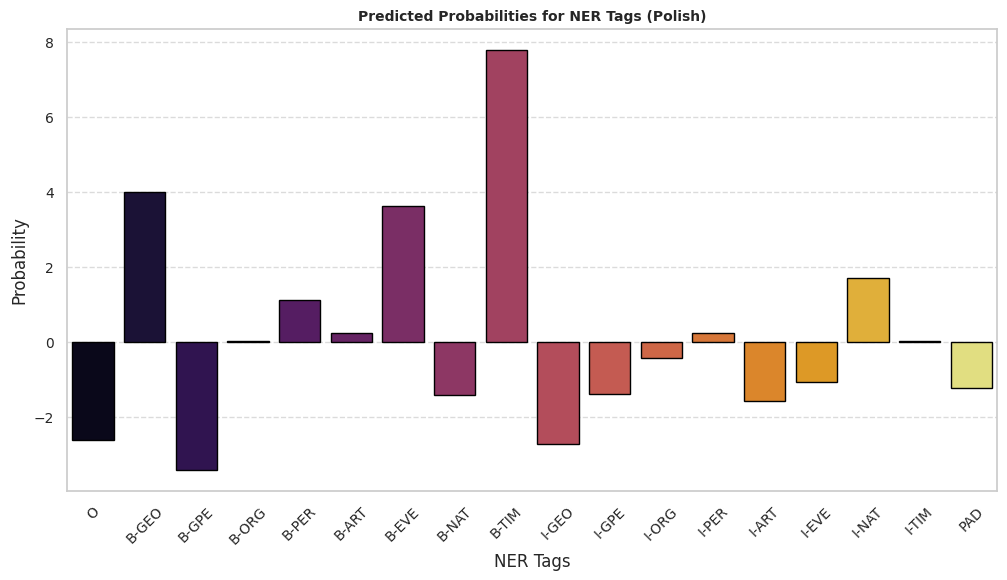

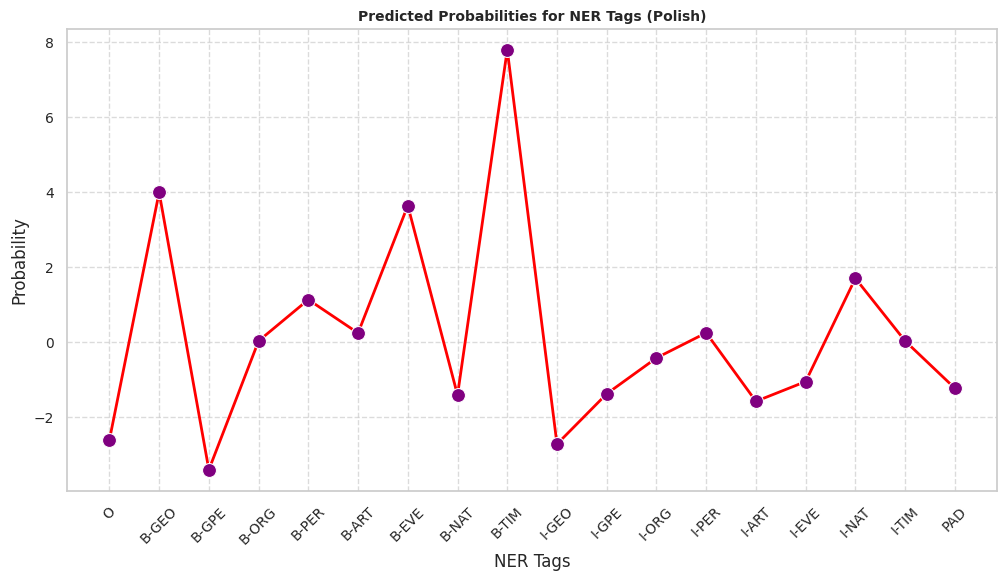

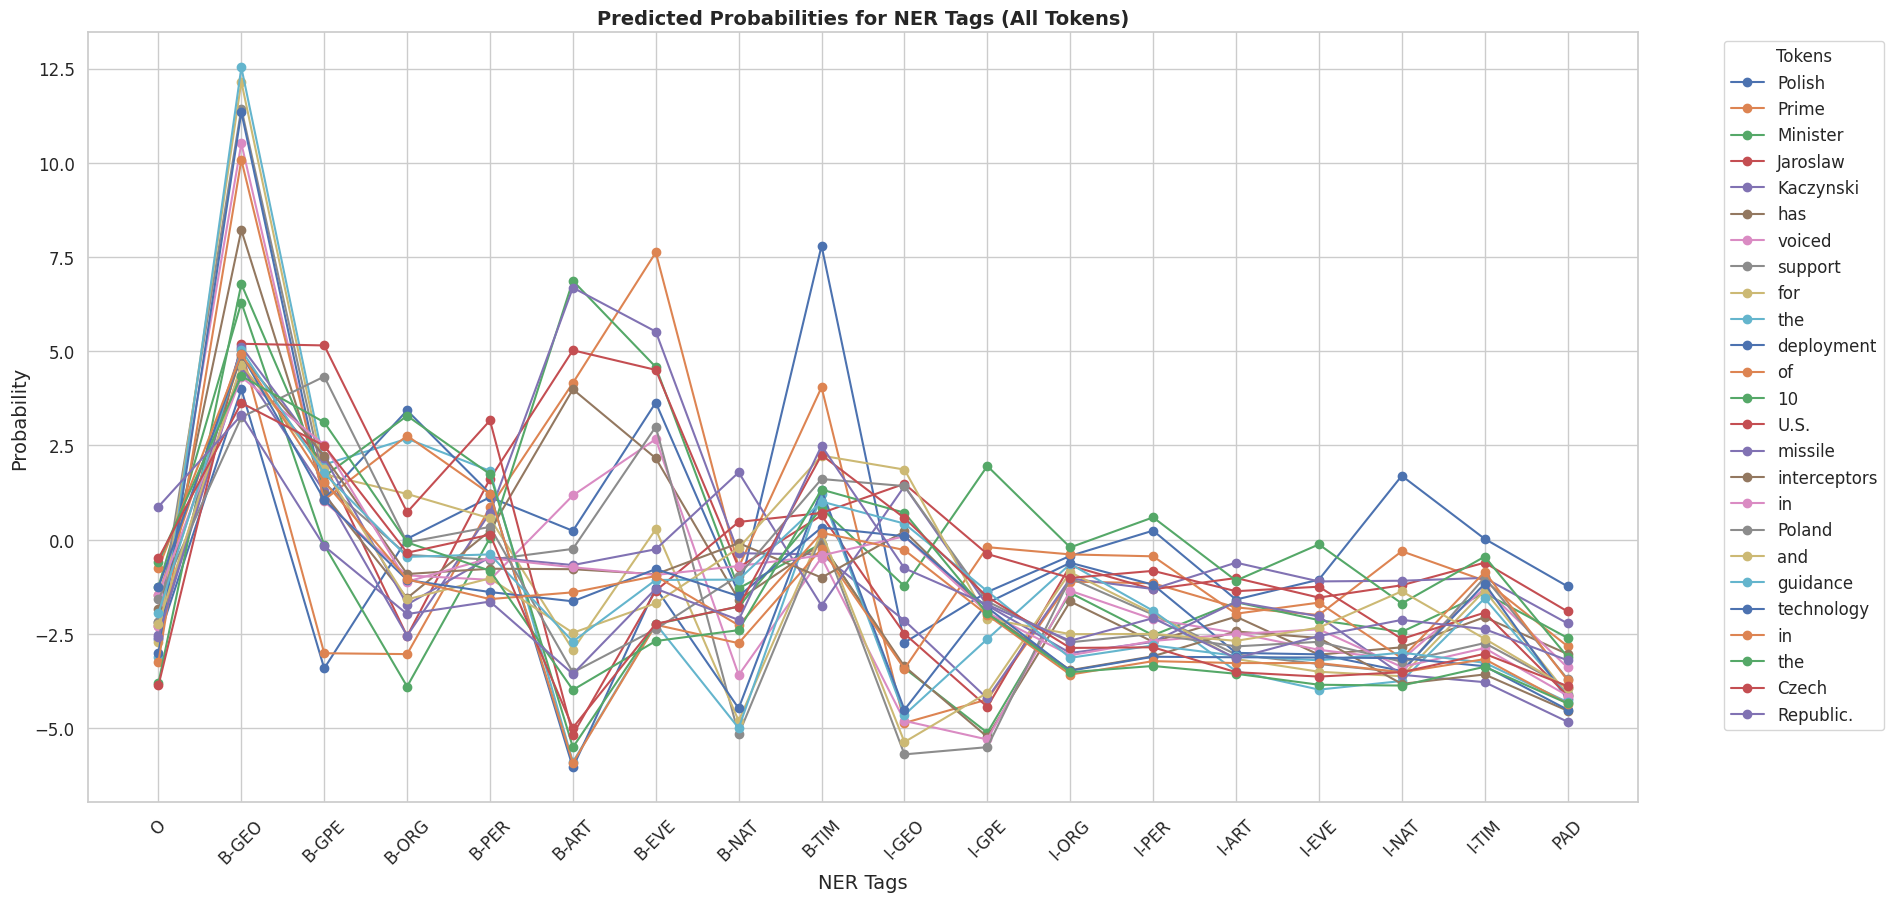

In [33]:
# Bar Plot for the first token
plt.figure(figsize=(12, 6))
sns.barplot(x=unique_tags, y=predictions[0][0], palette='inferno', edgecolor='black')
plt.title(f'Predicted Probabilities for NER Tags ({example_sentence[0]})', fontsize=10, weight='bold')
plt.xlabel('NER Tags', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Line Plot for the first token
plt.figure(figsize=(12, 6))
sns.lineplot(x=unique_tags, y=predictions[0][0], marker='o', linestyle='-', color='red', markerfacecolor='purple', markersize=10, lw=2)
plt.title(f'Predicted Probabilities for NER Tags ({example_sentence[0]})', fontsize=10, weight='bold')
plt.xlabel('NER Tags', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


plt.figure(figsize=(20, 10))
# Plotting line plots for each token
for i, token in enumerate(example_sentence):
    plt.plot(unique_tags, predictions[0][i], label=token, marker='o')

plt.title('Predicted Probabilities for NER Tags (All Tokens)', fontsize=14, weight='bold')
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Tokens', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)
plt.show()

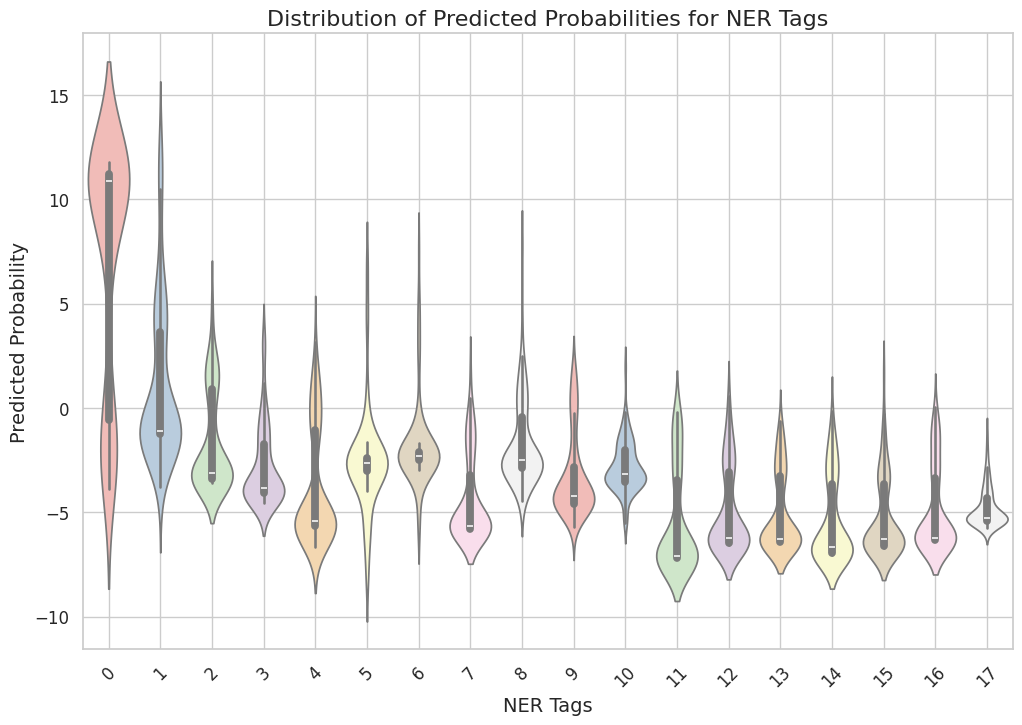

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 31.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 46.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 40.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 38.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 50.6% of the points cannot be plac

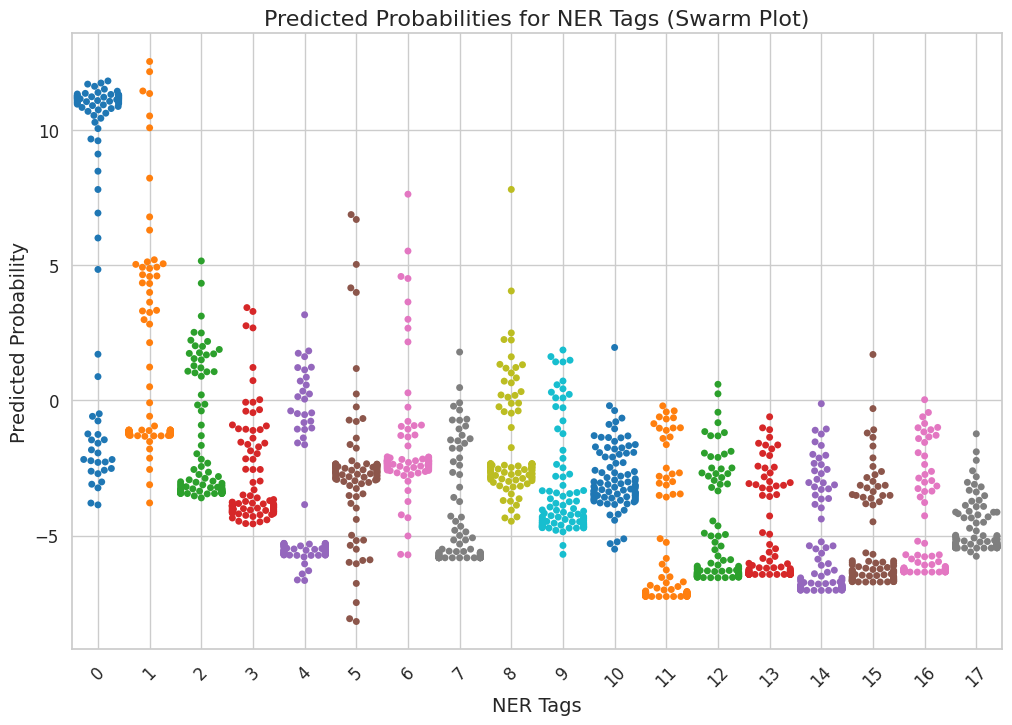

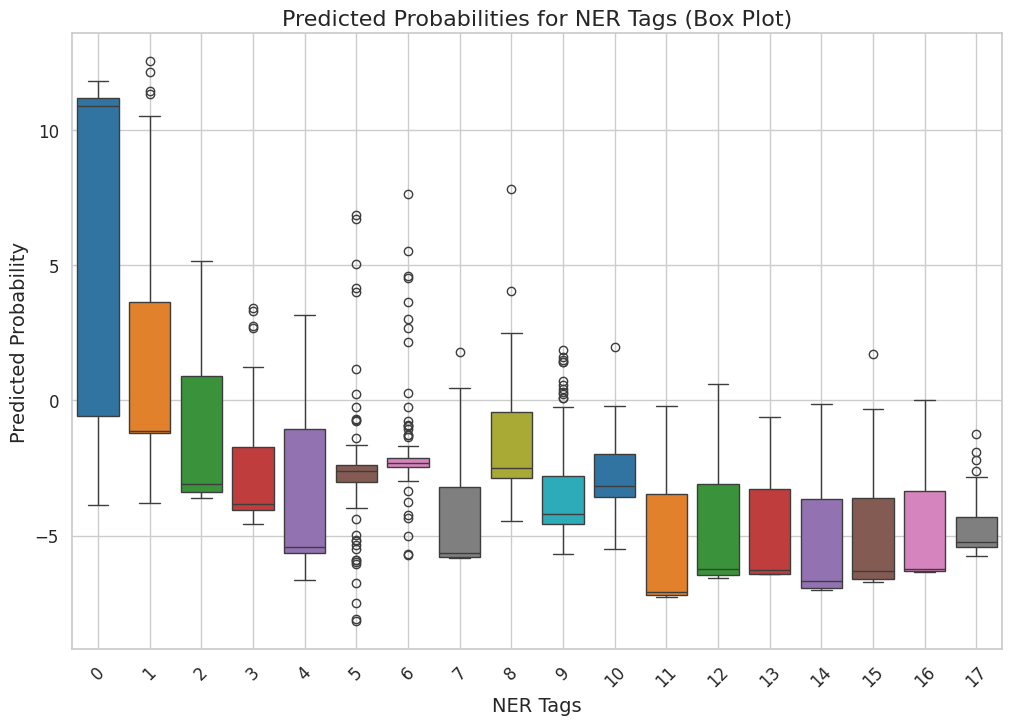

<ipython-input-34-96c516728550>:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=predictions[0], markers='o', join=False, ci='sd')
<ipython-input-34-96c516728550>:36: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=predictions[0], markers='o', join=False, ci='sd')


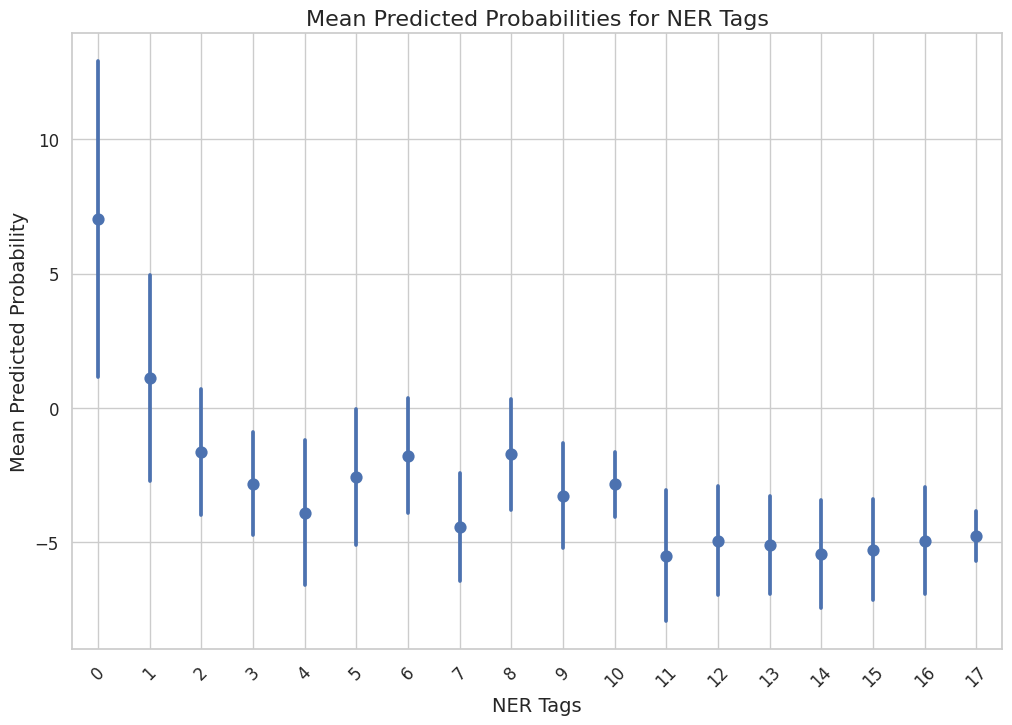

In [34]:
# Violin Plot
plt.figure(figsize=(12, 8))
sns.violinplot(data=predictions[0], palette='Pastel1')
plt.title('Distribution of Predicted Probabilities for NER Tags', fontsize=16)
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Predicted Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# Swarm Plot
plt.figure(figsize=(12, 8))
sns.swarmplot(data=predictions[0], palette='tab10', size=5)
plt.title('Predicted Probabilities for NER Tags (Swarm Plot)', fontsize=16)
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Predicted Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=predictions[0], palette='tab10')
plt.title('Predicted Probabilities for NER Tags (Box Plot)', fontsize=16)
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Predicted Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# Point Plot
plt.figure(figsize=(12, 8))
sns.pointplot(data=predictions[0], markers='o', join=False, ci='sd')
plt.title('Mean Predicted Probabilities for NER Tags', fontsize=16)
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Mean Predicted Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()